In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
class MazeProblem:

    def __init__(self, initial_state=(0, 0)):
        self.initial_state = initial_state
        self.goal_state = None
        self.maze = None

    def generate_maze(self, size=100, wall_density=0.3):
        self.size = size
        maze = np.zeros((size, size), dtype=int)


        for i in range(size):
            for j in range(size):
                maze[i, j] = 0

        maze[0, 0] = 1
        maze[size - 1, size - 1] = 1

        current_cell = (0, 0)
        stack = [current_cell]

        while stack:
            current_cell = stack[-1]
            x, y = current_cell

            directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]
            random.shuffle(directions)

            found_valid_move = False
            for delta_x, delta_y in directions:
                new_x, new_y = x + delta_x , y + delta_y

                if 0 <= new_x < size and 0 <= new_y < size and maze[new_x , new_y] == 0:
                    maze[new_x, new_y] = 1
                    maze[x + delta_x // 2, y + delta_y // 2] = 1
                    stack.append((new_x , new_y))
                    found_valid_move = True
                    break

            if not found_valid_move:
                stack.pop()

        self.maze = maze
        return maze

    def make_it_dynamic(self, maze, fire_ratio=0.05, min_distance=3):
        updated_maze = maze.copy()
        self.size = maze.shape[0]

        num_fires = int(self.size * self.size * fire_ratio)
        fire_positions = []

        valid_positions = [(x, y) for x in range(self.size) for y in range(self.size) if updated_maze[x, y] == 1]

        random.shuffle(valid_positions)

        for x, y in valid_positions:
            if len(fire_positions) >= num_fires:
                break

            if all(abs(x - fire_x) >= min_distance or abs(y - fire_y) >= min_distance for fire_x , fire_y in fire_positions):
                updated_maze[x, y] = 3
                fire_positions.append((x, y))

        self.maze = updated_maze
        return updated_maze



    def action(self, state, maze):
        actions = []
        x, y = state
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right
        jumps = [(-2, 0), (2, 0), (0, -2), (0, 2)]  # Jump


        for delta_x, delta_y in directions:
            new_x, new_y = x + delta_x, y + delta_y
            if 0 <= new_x < self.size and 0 <= new_y < self.size and maze[new_x, new_y] in [1, 3]:
                actions.append((new_x, new_y))


        for delta_x, delta_y in jumps:
            new_x, new_y = x + delta_x, y + delta_y
            mid_x, mid_y = x + delta_x // 2, y + delta_y // 2
            if (0 <= new_x < self.size and 0 <= new_y < self.size and maze[new_x, new_y] == 1 and maze[mid_x, mid_y] == 3):
                actions.append((new_x, new_y))

        return actions


    def generate_initial_goal(self, maze):
        self.initial_state = self.get_random_position(maze)
        self.goal_state = self.get_random_position(maze)
        return self.initial_state, self.goal_state

    def get_random_position(self, maze):
        while True:
            x, y = np.random.randint(0, self.size), np.random.randint(0, self.size)
            if maze[x, y] not in [0, 3]:
                return (x, y)

    def expand(self, state, maze):
        return self.action(state, maze)

    def path_cost(self, path):
        return len(path)

    def is_goal(self, state):
        return state == self.goal_state

    def visualize_maze(self):
        plt.figure(figsize=(10, 10))
        cmap = plt.cm.colors.ListedColormap(['black', 'white', 'red'])
        plt.imshow(self.maze, cmap=cmap, origin='upper', interpolation='nearest')

        plt.scatter(self.initial_state[1], self.initial_state[0], c='blue', s=100, marker='^', label="Start")
        plt.scatter(self.goal_state[1], self.goal_state[0], c='green', s=100, marker='*', label="Goal")

        fire_patch = plt.Line2D([0], [0], marker='s', color='w', label='Fire', markersize=10, markerfacecolor='red')
        start_patch = plt.Line2D([0], [0], marker='^', color='w', label='Start', markersize=10, markerfacecolor='blue')
        goal_patch = plt.Line2D([0], [0], marker='*', color='w', label='Goal', markersize=10, markerfacecolor='green')

        plt.legend(handles=[start_patch, goal_patch, fire_patch], loc='upper left')

        ax = plt.gca()
        ax.set_xticks(np.arange(-.5, self.size, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.size, 1), minor=True)
        ax.set_xticks([], minor=False)
        ax.set_yticks([], minor=False)
        ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

        ax.set_xticklabels([])
        ax.set_yticklabels([])

        plt.title('Maze Visualization')
        plt.show()


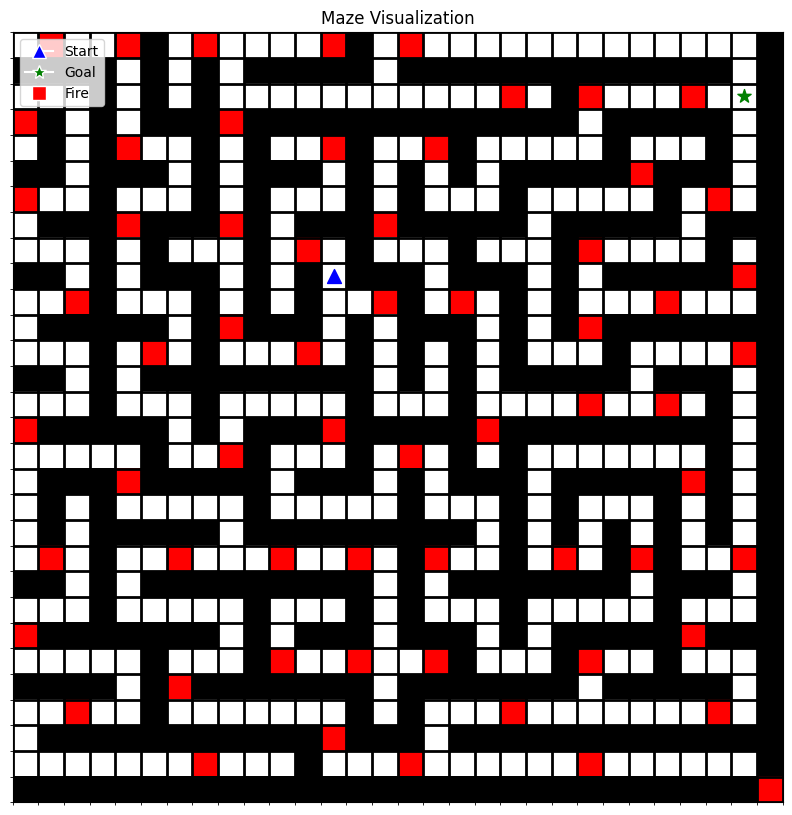

In [ ]:
maze_problem_30 = MazeProblem()
initial_maze_30 = maze_problem_30.generate_maze(size=30, wall_density=0.2)
dynamic_maze_30 = maze_problem_30.make_it_dynamic(initial_maze_30 , fire_ratio=0.1)
initial_state_30, goal_state_30 = maze_problem_30.generate_initial_goal(dynamic_maze_30)
maze_problem_30.visualize_maze()

In [ ]:
import matplotlib.animation as animation

In [ ]:
class Q_Learning:

    def __init__(self, maze_problem, learning_rate=0.001, discount_factor=0.9, Epsilon_value=0.2 , k=1):
        self.maze_problem = maze_problem
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.Epsilon_value = Epsilon_value
        self.k = k
        self.Q_Values = {}
        self.Visit_counts = {}
        self.Reget_history = []
        self.Episode_rewaeds = []
        self.initial_Q_Values()

    def initial_Q_Values(self):
        for x in range(self.maze_problem.size):
            for y in range(self.maze_problem.size):
                state = (x, y)
                self.Q_Values[state] = {}
                self.Visit_counts[state] = {}

    def Calculate_regret(self , optimal_reward , current_reward):
        return optimal_reward - current_reward

    def Exploration_function(self , utility , Visit_counts):
        Exploration_fun = utility + self.k / (Visit_counts + 1)
        return Exploration_fun

    def choose_action(self, state, test=False):
        valid_actions = self.maze_problem.action(state, self.maze_problem.maze)

        if not valid_actions:
            return None

        for action in valid_actions:
            if action not in self.Q_Values[state]:
                self.Q_Values[state][action] = 0
                self.Visit_counts[state][action] = 0

        if test:
            return max(valid_actions, key=lambda action : self.Q_Values[state].get(action , 0))
        else:
            if np.random.rand() < self.Epsilon_value:
                return random.choice(valid_actions)
            else:
                return max(valid_actions, key=lambda action: self.Exploration_function(self.Q_Values[state].get(action, 0), self.Visit_counts[state].get(action, 0)))


    def Calculate_reward(self, state):
        if state == self.maze_problem.goal_state:
            return 100
        elif self.maze_problem.maze[state[0], state[1]] == 3:
            return -5
        elif self.maze_problem.maze[state[0], state[1]] == 0:
            return -10
        else:
            return -1

    def Take_action(self, state, action):
        next_state = action
        reward = self.Calculate_reward(next_state)
        return next_state, reward

    def Update_Q_Values(self, state, action, reward, next_state):
        self.Visit_counts[state][action] += 1
        Max_next_Q_value = max(self.Q_Values[next_state].values(), default=0)
        current_Q_value = self.Q_Values[state].get(action, 0)
        Error = reward + self.discount_factor * Max_next_Q_value - current_Q_value
        self.Q_Values[state][action] = current_Q_value + self.learning_rate * Error

    def Train(self, episodes=1000):

        optimal_reward = 100
        episode_paths = {}

        for episode in range(episodes):
            state = self.maze_problem.initial_state
            current_reward = 0
            path = [state]

            for step in range(100):
                action = self.choose_action(state)
                if action is None:
                    break
                next_state, reward = self.Take_action(state, action)
                self.Update_Q_Values(state, action, reward, next_state)
                state = next_state
                current_reward += reward
                if self.maze_problem.is_goal(state):
                    break

            regret = self.Calculate_regret(optimal_reward, current_reward)
            self.Reget_history.append(regret)
            self.Episode_rewaeds.append(current_reward)

            self.Epsilon_value *= 0.99
            self.learning_rate *= 0.99

            if episode % 100 == 0:
              print(f"Episode: {episode}, Current Reward: {current_reward}, Regret: {regret}")



    def Visualize_Q_Values(self):

        plt.figure(figsize=(10, 10))
        cmap = plt.cm.colors.ListedColormap(['black', 'white', 'red'])
        plt.imshow(self.maze_problem.maze, cmap=cmap, origin='upper', interpolation='nearest')

        for state, actions in self.Q_Values.items():
            x, y = state
            for action, value in actions.items():
                dx, dy = action[0] - x, action[1] - y
                plt.arrow(y, x, dy, dx, head_width=0.1, head_length=0.2, fc='blue', ec='blue', length_includes_head=True, alpha=0.5)
                plt.text(y + dy / 2, x + dx / 2, f"{value:.2f}", color='black', ha='center', va='center', fontsize=8)

        plt.scatter(self.maze_problem.initial_state[1], self.maze_problem.initial_state[0], c='blue', s=100, marker='^', label="Start")
        plt.scatter(self.maze_problem.goal_state[1], self.maze_problem.goal_state[0], c='green', s=100, marker='*', label="Goal")

        fire_patch = plt.Line2D([0], [0], marker='s', color='w', label='Fire', markersize=10, markerfacecolor='red')
        start_patch = plt.Line2D([0], [0], marker='^', color='w', label='Start', markersize=10, markerfacecolor='blue')
        goal_patch = plt.Line2D([0], [0], marker='*', color='w', label='Goal', markersize=10, markerfacecolor='green')

        plt.legend(handles=[start_patch, goal_patch, fire_patch], loc='upper left')

        ax = plt.gca()
        ax.set_xticks(np.arange(-.5, self.maze_problem.size, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.maze_problem.size, 1), minor=True)
        ax.set_xticks([], minor=False)
        ax.set_yticks([], minor=False)
        ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

        ax.set_xticklabels([])
        ax.set_yticklabels([])

        plt.title('Q-Values Visualization')
        plt.show()

    def Print_Q_Values(self):
        print("Q-Values:")
        for state, actions in self.Q_Values.items():
            print(f"State: {state}")
            for action, value in actions.items():
                print(f"  Action: {action}, Q-value: {value}")


    def Test(self):
        state = self.maze_problem.initial_state
        path = [state]

        while not self.maze_problem.is_goal(state):
            action = self.choose_action(state, test=True)
            if action is None:
                print("No valid actions available!")
                break

            state = action
            path.append(state)

        if self.maze_problem.is_goal(state):
            print("Goal reached!")
        else:
            print("Failed to reach the goal.")
        return path

    def Visualize_path(self, path):
        plt.figure(figsize=(10, 10))
        cmap = plt.cm.colors.ListedColormap(['black', 'white', 'red'])
        plt.imshow(self.maze_problem.maze, cmap=cmap, origin='upper', interpolation='nearest')

        plt.scatter(self.maze_problem.initial_state[1], self.maze_problem.initial_state[0], c='blue', s=100, marker='^', label="Start")
        plt.scatter(self.maze_problem.goal_state[1], self.maze_problem.goal_state[0], c='green', s=100, marker='*', label="Goal")

        fire_patch = plt.Line2D([0], [0], marker='s', color='w', label='Fire', markersize=10, markerfacecolor='red')
        start_patch = plt.Line2D([0], [0], marker='^', color='w', label='Start', markersize=10, markerfacecolor='blue')
        goal_patch = plt.Line2D([0], [0], marker='*', color='w', label='Goal', markersize=10, markerfacecolor='green')

        for (y, x) in path:
            plt.scatter(x, y, c='orange', s=100, marker='o', label="Path")

        plt.legend(handles=[start_patch, goal_patch, fire_patch], loc='upper left')

        ax = plt.gca()
        ax.set_xticks(np.arange(-.5, self.maze_problem.size, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.maze_problem.size, 1), minor=True)
        ax.set_xticks([], minor=False)
        ax.set_yticks([], minor=False)
        ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

        ax.set_xticklabels([])
        ax.set_yticklabels([])

        plt.title('Maze Solution Path Visualization')
        plt.show()

In [ ]:
Q_learning_agent = Q_Learning(maze_problem_30, learning_rate=0.1, discount_factor=0.95, Epsilon_value=0.1)
Q_learning_agent.Train(episodes=10000)

Episode: 0, Current Reward: -152, Regret: 252
Episode: 100, Current Reward: -128, Regret: 228
Episode: 200, Current Reward: -108, Regret: 208
Episode: 300, Current Reward: -112, Regret: 212
Episode: 400, Current Reward: -112, Regret: 212
Episode: 500, Current Reward: -116, Regret: 216
Episode: 600, Current Reward: -112, Regret: 212
Episode: 700, Current Reward: -108, Regret: 208
Episode: 800, Current Reward: -104, Regret: 204
Episode: 900, Current Reward: -104, Regret: 204
Episode: 1000, Current Reward: -116, Regret: 216
Episode: 1100, Current Reward: -104, Regret: 204
Episode: 1200, Current Reward: 17, Regret: 83
Episode: 1300, Current Reward: 9, Regret: 91
Episode: 1400, Current Reward: -1, Regret: 101
Episode: 1500, Current Reward: 49, Regret: 51
Episode: 1600, Current Reward: -100, Regret: 200
Episode: 1700, Current Reward: 39, Regret: 61
Episode: 1800, Current Reward: 5, Regret: 95
Episode: 1900, Current Reward: -100, Regret: 200
Episode: 2000, Current Reward: 63, Regret: 37
Episo

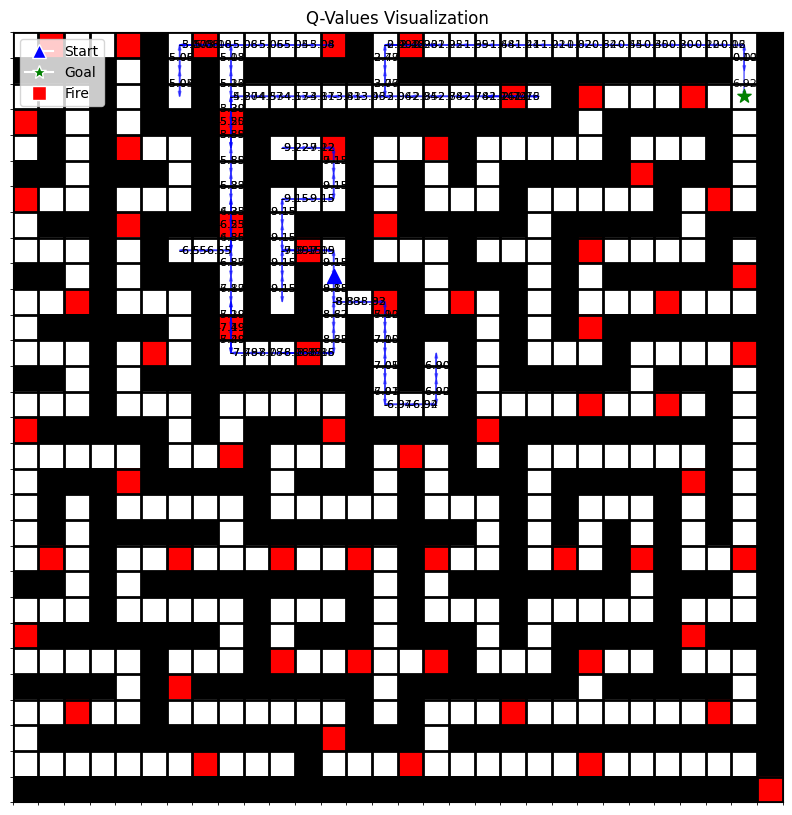

In [ ]:
Q_learning_agent.Visualize_Q_Values()

Goal reached!


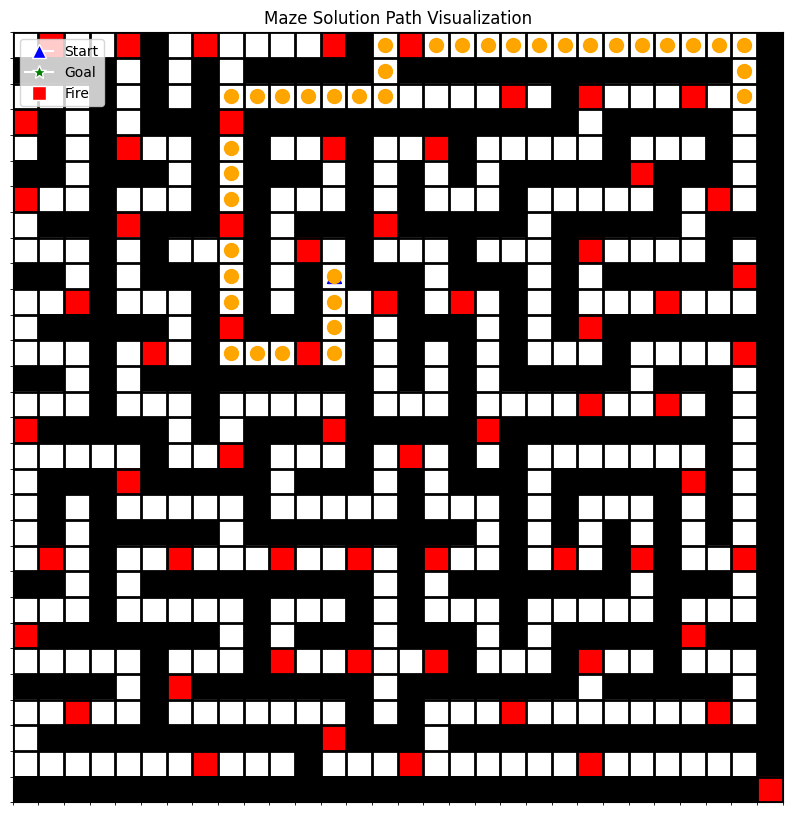

In [ ]:
path = Q_learning_agent.Test()
Q_learning_agent.Visualize_path(path)

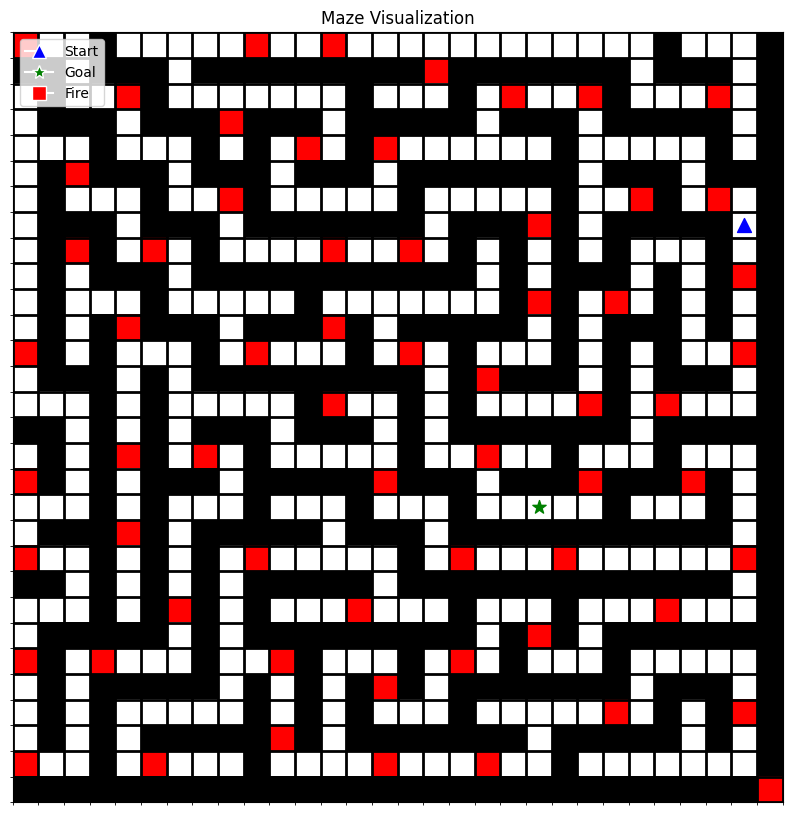

In [ ]:
maze_problem = MazeProblem()
initial_maze= maze_problem.generate_maze(size=30, wall_density=0.2)
dynamic_maze = maze_problem.make_it_dynamic(initial_maze , fire_ratio=0.1)
initial_state, goal_state = maze_problem.generate_initial_goal(dynamic_maze)
maze_problem.visualize_maze()

In [ ]:
Q_learning_agent_2 = Q_Learning(maze_problem, learning_rate=0.1, discount_factor=0.95, Epsilon_value=0.1)
Q_learning_agent_2.Train(episodes=10000)

Episode: 0, Current Reward: -140, Regret: 240
Episode: 100, Current Reward: 84, Regret: 16
Episode: 200, Current Reward: 84, Regret: 16
Episode: 300, Current Reward: -124, Regret: 224
Episode: 400, Current Reward: 86, Regret: 14
Episode: 500, Current Reward: 86, Regret: 14
Episode: 600, Current Reward: 84, Regret: 16
Episode: 700, Current Reward: 86, Regret: 14
Episode: 800, Current Reward: 86, Regret: 14
Episode: 900, Current Reward: 86, Regret: 14
Episode: 1000, Current Reward: 86, Regret: 14
Episode: 1100, Current Reward: 86, Regret: 14
Episode: 1200, Current Reward: 86, Regret: 14
Episode: 1300, Current Reward: 86, Regret: 14
Episode: 1400, Current Reward: 86, Regret: 14
Episode: 1500, Current Reward: 86, Regret: 14
Episode: 1600, Current Reward: 86, Regret: 14
Episode: 1700, Current Reward: 86, Regret: 14
Episode: 1800, Current Reward: 86, Regret: 14
Episode: 1900, Current Reward: 86, Regret: 14
Episode: 2000, Current Reward: 86, Regret: 14
Episode: 2100, Current Reward: 86, Regre

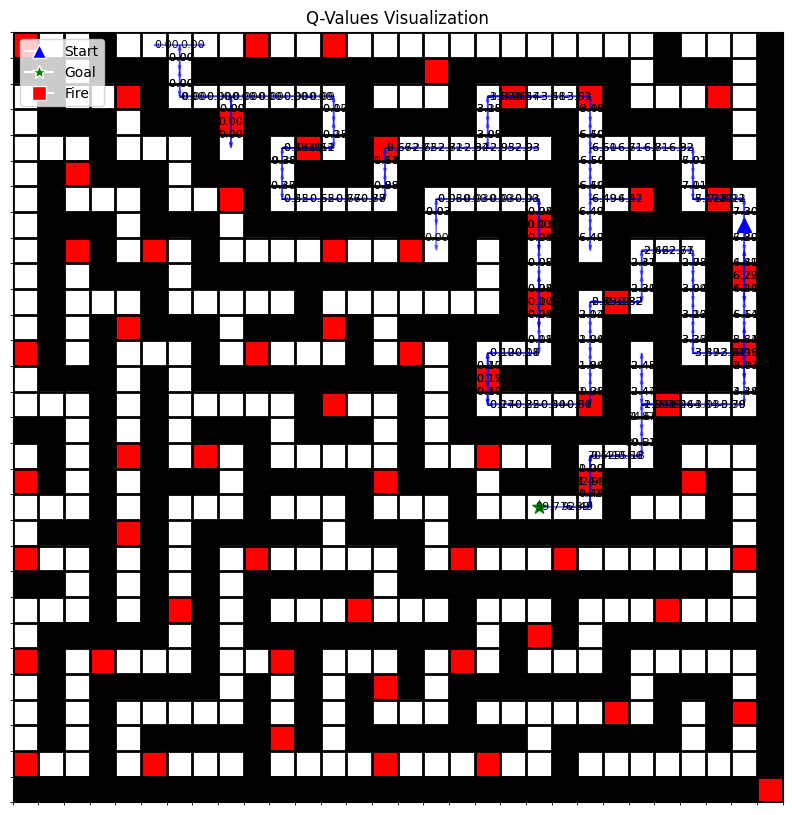

In [ ]:
Q_learning_agent_2.Visualize_Q_Values()

Goal reached!


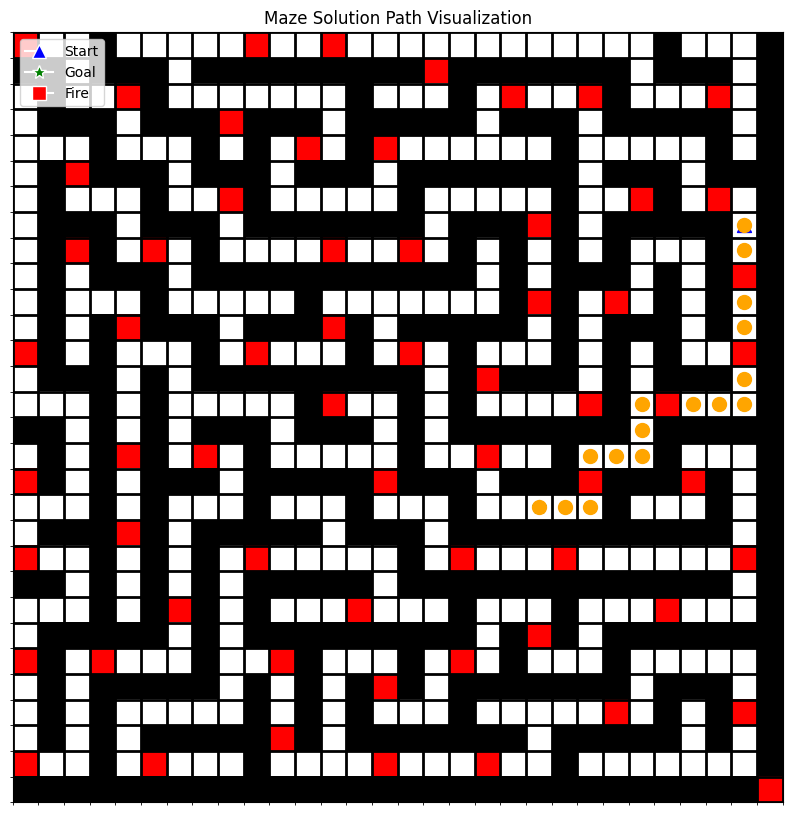

In [ ]:
path = Q_learning_agent_2.Test()
Q_learning_agent_2.Visualize_path(path)